# First Data Science Project
## Melbourne Housing Prices Prediction
Here, we will go through a data challenge using data predicting housing prices in Melbourne, Australia. 

The data is from Kaggle and can be found [here](https://www.kaggle.com/anthonypino/melbourne-housing-market)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [3]:
df = pd.read_csv('./data/Melbourne_housing_clean.csv')

In [4]:
df.head()

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,1.0,1.0,202.0,NaN,NO_INFORMATION,Yarra City Council,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,1.0,0.0,156.0,79.0,1900.0,Yarra City Council,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,2.0,0.0,134.0,150.0,1900.0,Yarra City Council,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,2.0,1.0,94.0,NaN,NO_INFORMATION,Yarra City Council,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,1.0,2.0,120.0,142.0,2014.0,Yarra City Council,Northern Metropolitan,4019.0


## Data Assessment

In [5]:
df.isnull().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price                0
Method               0
SellerG              0
Date                 0
Distance             0
Postcode             0
Bathroom          6444
Car               6821
Landsize          9262
BuildingArea     16588
YearBuilt            0
CouncilArea          0
Regionname           0
Propertycount        0
dtype: int64

For the first Iteration drop all variables with nan Values: BuildingArea and Landsize

In [6]:
df.drop(columns = ['Bathroom', 'Car', 'Landsize', 'BuildingArea'], inplace=True)

Drop possibly redundant columns regarding the location: Address and CouncilArea

In [7]:
df.drop(columns = ['Address', 'CouncilArea'], inplace = True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27244 entries, 0 to 27243
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Suburb         27244 non-null  object 
 1   Rooms          27244 non-null  int64  
 2   Type           27244 non-null  object 
 3   Price          27244 non-null  float64
 4   Method         27244 non-null  object 
 5   SellerG        27244 non-null  object 
 6   Date           27244 non-null  object 
 7   Distance       27244 non-null  float64
 8   Postcode       27244 non-null  float64
 9   YearBuilt      27244 non-null  object 
 10  Regionname     27244 non-null  object 
 11  Propertycount  27244 non-null  float64
dtypes: float64(4), int64(1), object(7)
memory usage: 2.5+ MB


Notice that Postcode and YearBuilt are not properly configured (data type)

In [9]:
# first change the data type of the Postcode (remember it is not ordered)
df.Postcode = df.Postcode.astype('str')

In [10]:
def create_cat_var(df, var):
    '''
    INPUT:
    - df: DataFrame
    - var: Variable or column to be saved as an ordered category
    
    OUTPUT:
    Dataframe with the correct datatype for the given variable
    '''
    
    # make sure the var is a string
    df[var] = df[var].astype('str')
    
    # create an ordered list sorted by the values
    ordered_list = list(df[var].value_counts().sort_index().index)
    
    # create the categorical element
    cat_element = pd.api.types.CategoricalDtype(ordered=True, categories = ordered_list)
    
    # change the category of the var:
    df[var] = df[var].astype(cat_element)
    
    return df

In [11]:
#Use the previous function to change the datatype of YearBuilt and Date to category

df = create_cat_var(df, 'YearBuilt')
df = create_cat_var(df, 'Date')

Look for outlyers by calculating the relative distance between the max value and the 98th percentil

In [12]:
# calculate the relative distance between max value and 98 percentile

num_var = df.select_dtypes(include = ['float', 'int64'])

list_rel_dist = []
for var in num_var:
    max_value = df[var].max()
    percentile_98 = np.percentile(df[var], 98)
    rel_dist = max_value/percentile_98
    list_rel_dist.append(rel_dist)

# create a dataframe with the values for the relative distance
dict_1 = dict(variables = list(num_var))
dict_2 = dict(values = list_rel_dist)

# set the dictionary
dict_1.update(dict_2)

# set the dataframe
rel_dist_df = pd.DataFrame(data=dict_1)

# show dataframe
rel_dist_df.sort_values('values', ascending=False)

,variables,values
1,Price,3.91962
0,Rooms,3.20000
2,Distance,1.51735
3,Propertycount,1.00000


For Price and Rooms we have some outliers, for which we will keep 98% of the data by getting rid of everything that is above the 98th percentile

Get rid of the outlyers from Car, Bedroom, Price and Bathroom

In [13]:
var_with_outl = ['Price', 'Rooms']

In [14]:
# function to get rid of outlyers

def get_rid_of_outl(df, list_of_columns, percentile):
    """
    INPUT:
    df: DataFrame
    list_of_columns: list of columns for which the outliers have to be removed
    percentile: digit between 1 and 100 reprecenting the percentage of the data to keep
    
    OUTPUT:
    dataframe without outliers
    """
    
    perc_dict = {}
    for col in list_of_columns: # first, calculate all the percentiles before removing any
        # row, otherwise you will remove more rows than necessary
        value_perc = np.nanpercentile(df[col], percentile)
        value_perc_dict = {col: value_perc}
        perc_dict.update(value_perc_dict)
        
    for var in list_of_columns:    
        df = df.loc[(df[var] <= perc_dict[var]) ^ (df[var].isnull())] # include nan values
    
    return df

In [15]:
# get the size of the original table for comparison
df.shape

(27244, 12)

In [16]:
# get rid of outliers using the function
df = get_rid_of_outl(df, var_with_outl, 98)

In [17]:
# check the new size of the table
df.shape

(26542, 12)

## Univariate Data Exploration

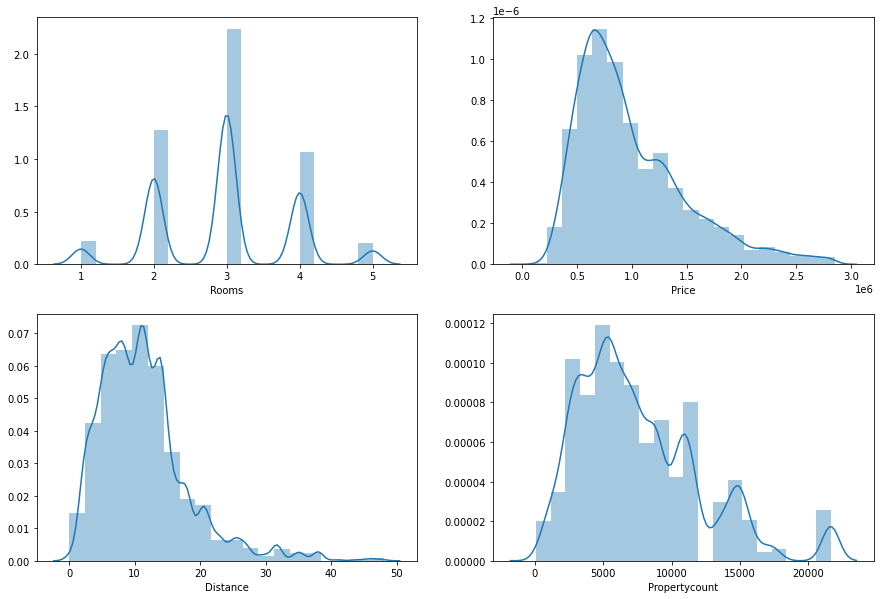

In [18]:
# Get the distribution of all the numerical variables

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
axs = axs.ravel()
for i, var in enumerate(num_var.columns):
    sns.distplot(df[var], bins=20, ax=axs[i]);

take a look to the categorical values:

In [19]:
cat_var = df.select_dtypes(include = ['object', 'category'])
cat_var.columns

Index(['Suburb', 'Type', 'Method', 'SellerG', 'Date', 'Postcode', 'YearBuilt',
       'Regionname'],
      dtype='object')

In [20]:
def countplot_cat_var(df, var):
    ordered_values = df[var].value_counts().sort_values(ascending=False).index
    plt.figure(figsize=(15,15))
    return sns.countplot(data = df, y=var, order=ordered_values);

<AxesSubplot:xlabel='count', ylabel='Suburb'>

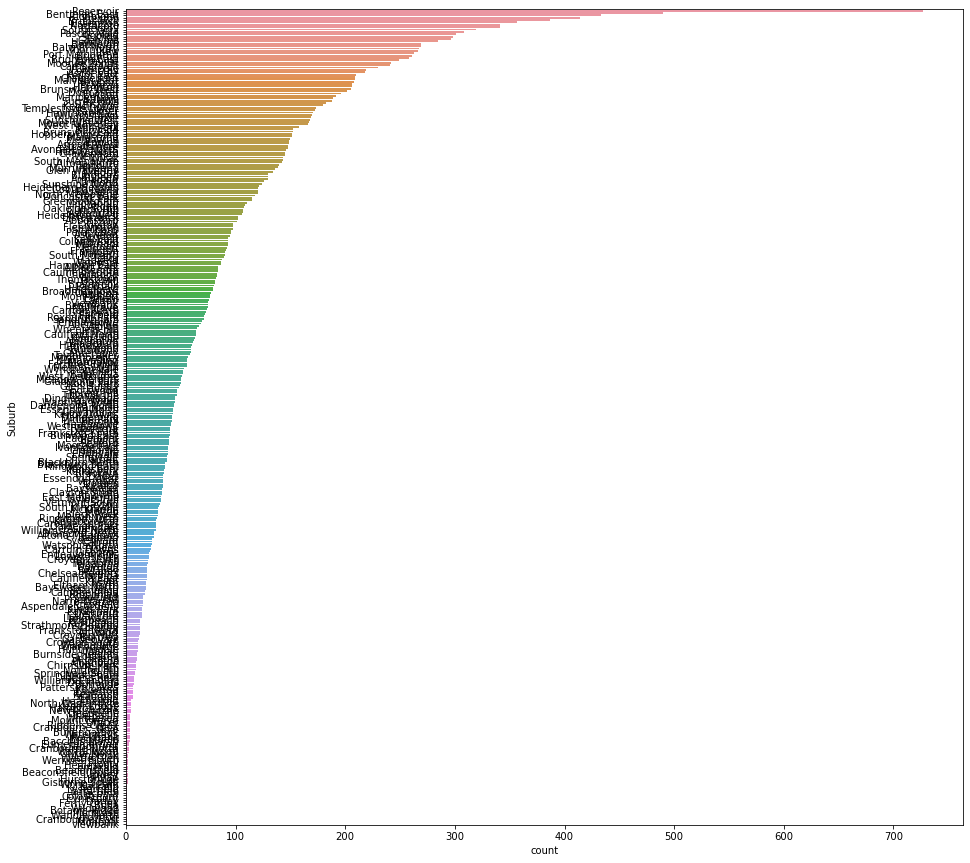

In [21]:
countplot_cat_var(df, 'Suburb')

The interesting part is the combination with price in the next section

## Multivariate Data Exploration

<AxesSubplot:>

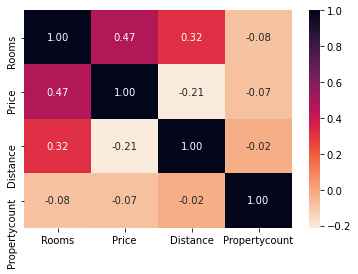

In [22]:
sns.heatmap(df.corr(), annot=True, fmt='.2f', cmap='rocket_r')

Now lets compare the categorical values to the price

In [23]:
def barplot_cat_var(df, cat_var, num_var):
    ordered_values = df.groupby([cat_var])[num_var].mean()\
                     .sort_values(ascending = False)
    
    plt.figure(figsize=(15,20))
    sns.barplot(data=df, y=cat_var, x=num_var, errwidth=0, order=ordered_values.index)
    plt.xlabel('Average Price')
    plt.ylabel(cat_var)
    x_values = list(ordered_values) 
         
    return plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

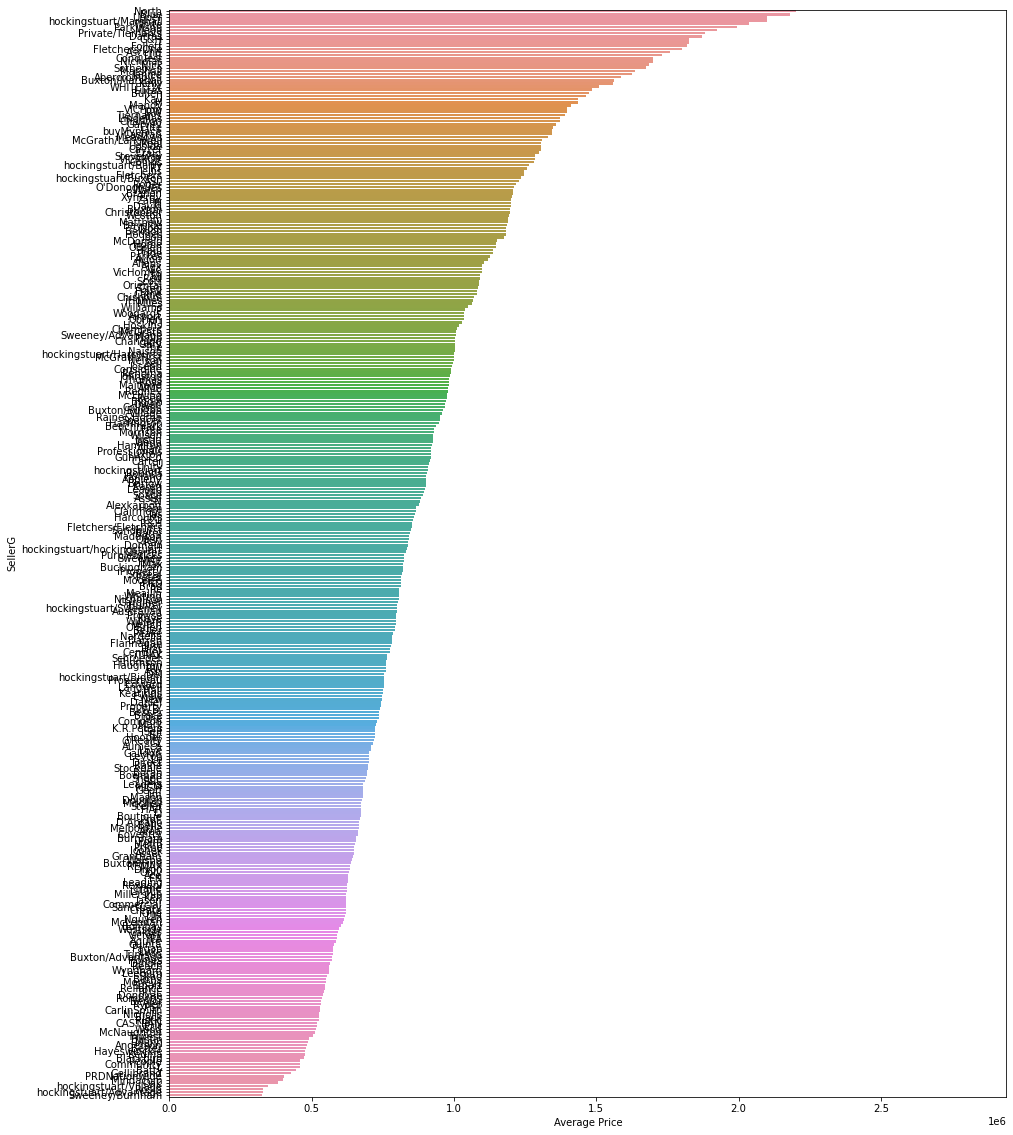

In [24]:
barplot_cat_var(df, 'SellerG', 'Price')

## Modeling

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from math import sqrt

In [26]:
# create dummy variables for the model:

for var in cat_var.columns:
    df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)

In [27]:
# define X and y
X = df[[i for i in df.columns if i != 'Price']]
y = df.Price

In [28]:
X.shape

(26542, 1140)

In [29]:
X.head()

,Rooms,Distance,Propertycount,Suburb_Aberfeldie,Suburb_Airport West,Suburb_Albanvale,Suburb_Albert Park,Suburb_Albion,Suburb_Alphington,Suburb_Altona,...,YearBuilt_2018.0,YearBuilt_2019.0,YearBuilt_NO_INFORMATION,Regionname_Eastern Victoria,Regionname_Northern Metropolitan,Regionname_Northern Victoria,Regionname_South-Eastern Metropolitan,Regionname_Southern Metropolitan,Regionname_Western Metropolitan,Regionname_Western Victoria
0,2,2.5,4019.0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
1,2,2.5,4019.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,3,2.5,4019.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,3,2.5,4019.0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
4,4,2.5,4019.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [30]:
# split the data set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [31]:
# fit the linear Regression:
OLS_object = LinearRegression(normalize=False)
OLS_model = OLS_object.fit(X_train, y_train)

In [32]:
# Test the accuracy
y_pred = OLS_model.predict(X_test)
OLS_RMSE = sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
OLS_RMSE

258572.2972543084

In [33]:
# get the r2
OLS_r2 = r2_score(y_true=y_test, y_pred=y_pred)
OLS_r2

0.7210442164270285

In [2]:
import numpy
numpy.version.version

'1.19.1'